### Installing the dependencies

In [16]:
# !pip install youtube-transcript-api
# !pip install PyPDF2
# !pip install langchain
# !pip install langchain-groq
# !pip install "langserve[all]"
# !pip install langchain_community
# !pip install chromadb
# !pip install langchain-experimental

### Importing the libraries

In [ ]:
import os
import io
import base64
import re
import numpy as np
from youtube_transcript_api import YouTubeTranscriptApi
from PyPDF2 import PdfReader
from langchain_core.embeddings import Embeddings
from langchain.schema.document import Document
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from rich import print
from google.colab import userdata
print("Everything Imported Succesfully✅")

Everything Imported Succesfully✅

### Loading the models

In [8]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [10]:
# Loading the LLM model
model = ChatGroq(model="llama3-8b-8192")

# Embedding Model
embedding_model = HuggingFaceInferenceAPIEmbeddings(api_key =userdata.get('HF_TOKEN'),model_name="BAAI/bge-base-en-v1.5")


text_splitter_recursive = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

### Defining the utility fuctions

In [11]:
# Function to extract the video ID from the YouTube URL
def get_youtube_id(url):

    regex = (
        r'(https?://)?(www\.)?(youtube|youtu|youtube-nocookie)\.(com|be)/(watch\?v=|embed/|v/|.+\?v=)?([^&=%\?]{11})')
    match = re.match(regex, url)
    return match.group(6) if match else None

### Defining the RAG architecture

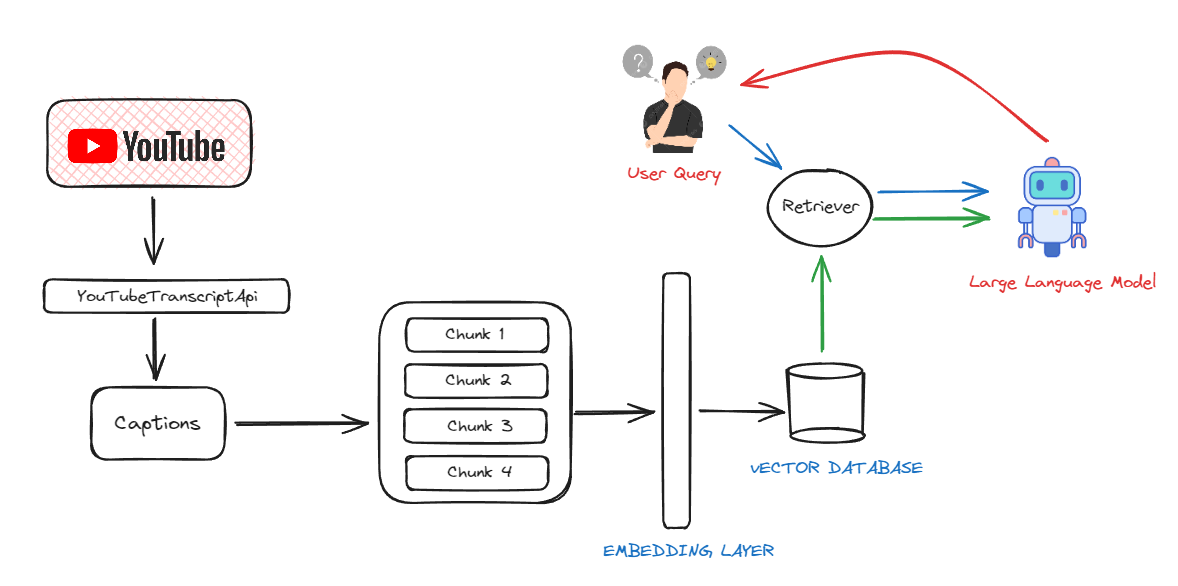

In [14]:
# Definign the rag system
def rag_system(youtube_id,collection_name,query,llm,embedding_model,text_splitter):

    # Fetching the transcript
    result = YouTubeTranscriptApi.get_transcript(youtube_id)
    yt_captions = ""
    for item in iter(result):
        yt_captions = yt_captions + item['text'] + ""

    # Creating the documents
    context_data = yt_captions
    documents = text_splitter.create_documents([context_data])

    # Defining the retriever
    vectorstore = Chroma.from_documents(
        documents=documents,
        collection_name=collection_name,
        embedding=embedding_model,
    )
    retriever = vectorstore.as_retriever()

    prompt_template = """Answer the question based only on the following context:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(prompt_template)

    # Chaining the runnables using the LECL
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    return chain.invoke(query)

In [15]:
%%time
youtube_link = "https://youtu.be/gqvFmK7LpDo?si=D2Ia8scckeKAPWaG"
video_id = get_youtube_id(youtube_link)
if video_id:
    query = input()
    result = rag_system(video_id,"test1",query,model,embedding_model,text_splitter_recursive)
    print(result)

What is the price of the course mentioned in the video?


According to the given context, the price of the course mentioned in the video is 399 rupees.

CPU times: user 1.15 s, sys: 64.7 ms, total: 1.21 s
Wall time: 19.9 s
